# TFM
## Clasificación de logotipos de marcas a través de visión artificial.
- Adquisición de fuentes de datos.
- Descripción de fuentes de datos.
- Análisis exploratorio de datos.
- Preprocesado de datos, reescalado de imágenes, eliminación de datos erróneos, obtención de matrices y tensores para su aplicación en frameworks de deep learning.
- Aplicación de una arquitectura de red.
- Obtención de resultados y métricas.
- Mejora de resultados.
- Búsqueda y aplicación de nuevas arquitecturas de red.
- Aumento y agregación de datos o aumento por transformación de las imágenes originales.
- Fine-tunning de los parámetros de la red.
- Obtención de nuevas métricas.
- Comparativa de resultados.
- (Opcional). Elaboración de un cuadro de mando o web app para mostrar los resultados y el proyecto a nivel funcional.

In [1]:
# Instalar biblioteca para descargar imagenes de bing
!pip install bing-image-downloader

In [2]:
# Bibliotecas necesarias para el trabajo
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models, transforms
from bing_image_downloader  import downloader
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import (RandomHorizontalFlip, RandomVerticalFlip,
                                    RandomRotation, ColorJitter, RandomAffine)

# Adquisición de fuentes de datos

## Descarga de imagenes de internet para obtener logotipos de marcas de comida rápida

In [3]:
# Lista de marcas
brands_logos = ["McDonald's logo", "Burger King logo", "KFC logo",
                "Popeyes logo", "Subway logo", "Taco Bell logo",
                "Domino's Pizza logo", "Pizza hut logo"]

# Obtener el directorio actual
download_dir = os.path.join(os.getcwd(),"dataset")

# Descargar imagenes para cada marca
for brand in brands_logos:
    downloader.download(brand, output_dir=download_dir)

[%] Downloading Images to /content/dataset/McDonald's logo


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from https://logos-download.com/wp-content/uploads/2016/03/McDonalds_logo_red.png
[!] Issue getting: https://logos-download.com/wp-content/uploads/2016/03/McDonalds_logo_red.png
[!] Error:: HTTP Error 404: Not Found
[%] Downloading Image #1 from http://logos-download.com/wp-content/uploads/2016/03/McDonalds_logo_red_America_USA.png
[!] Issue getting: http://logos-download.com/wp-content/uploads/2016/03/McDonalds_logo_red_America_USA.png
[!] Error:: HTTP Error 404: Not Found
[%] Downloading Image #1 from https://laurasenior94.files.wordpress.com/2014/10/plain-mcdonalds-logo.jpg
[Error]Invalid image, not saving https://laurasenior94.files.wordpress.com/2014/10/plain-mcdonalds-logo.jpg

[!] Issue getting: https://laurasenior94.files.wordpress.com/2014/10/plain-mcdonalds-logo.jpg
[!] Error:: Invalid image, not saving https://laurasenior94.files.word

In [4]:
# Lista para almacenar las imágenes y las etiquetas
images = []
labels = []

# Iteramos sobre cada marca en la lista de marcas y sus logotipos
for brand_id, brand in enumerate(brands_logos):
    # Construimos la ruta completa del directorio de la marca
    brand_path = os.path.join(download_dir, brand)

    # Iteramos sobre los archivos en el directorio de la marca
    for filename in os.listdir(brand_path):
        # Construimos la ruta completa de la imagen
        image_path = os.path.join(brand_path, filename)

        try:
            # Intentamos abrir la imagen y convertirla a modo RGB
            img = Image.open(image_path).convert("RGB")

            # Agregamos la imagen a la lista de imágenes
            images.append(img)

            # Agregamos la etiqueta de la marca a la lista de etiquetas
            labels.append(brand_id)
        except Exception as e:
            # Manejamos cualquier error que ocurra al cargar la imagen
            print(f"Error al cargar la imagen {image_path}: {e}")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Descripción de fuentes de datos
Imagenes con distintos formatos obtenidas mediante el buscador realizando web scrapping

# Análisis exploratorio de datos

In [5]:
print("Numero de imágenes recogidas:", len(images))

Numero de imágenes recogidas: 325


In [6]:
for i in range(5):
    print("Dimensinalidad de la imagen {}: {}".format(i, images[i].size))

Dimensinalidad de la imagen 0: (2048, 1366)
Dimensinalidad de la imagen 1: (4800, 3000)
Dimensinalidad de la imagen 2: (3840, 2160)
Dimensinalidad de la imagen 3: (3500, 2600)
Dimensinalidad de la imagen 4: (2400, 2400)


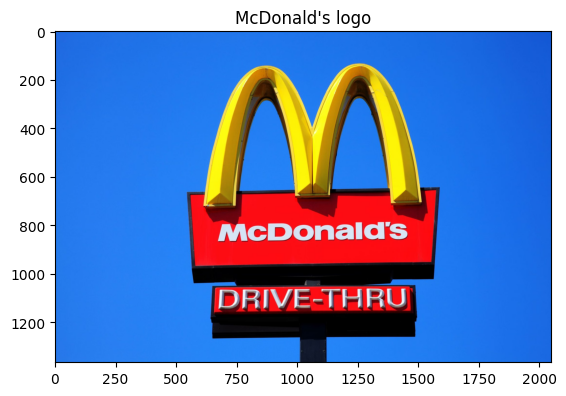

In [7]:
# Se pinta la imagen
plt.imshow(images[0])

# Se establece como titulo la marca de la imagen
plt.title(
    brands_logos[labels[0]]
)
plt.show()

In [8]:
print("Proporción de clases para cada imagen: ",
      np.unique(labels, return_counts = True))

Proporción de clases para cada imagen:  (array([0, 3, 4, 5, 6, 7]), array([59, 48, 62, 48, 52, 56]))


# Preprocesado de datos, reescalado de imágenes, eliminación de datos erróneos, obtención de matrices y tensores para su aplicación en frameworks de deep learning

In [9]:
# Media y desviación típica para normalizar las imagenes
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # Cambia el tamaño de las imagenes para que todas sean iguales
    transforms.ToTensor(), # Se crea el tensor de las imagenes
    transforms.Normalize(mean, std), # Se normalizan las imagenes
])

In [11]:
# Se aplican las transformaciones mencionadas a las imagenes
transformed_images = [transform(img) for img in images]

In [12]:
print(type(transformed_images[0]))  # Verifica el tipo de datos de un tensor
print(transformed_images[0].shape)  # Verifica la forma de un tensor

<class 'torch.Tensor'>
torch.Size([3, 224, 224])


In [13]:
# Se apilan los tensores de las imagenes
transformed_images = torch.stack(transformed_images)

# Se crea un dataset de tensores con las imagenes y las etiquetas
dataset = TensorDataset(transformed_images, torch.Tensor(labels))

In [14]:
# Se divide el dataset entre entrenamiento y prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [15]:
# Se comprueba si se esta usando gpu o cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Declaracion de variables para los modelos
BATCH_SIZE    = 32
EPOCHS        = 15
LEARNING_RATE = 3e-3
num_classes   = len(brands_logos)

In [17]:
# Se genera un dataloader para los lotes del modelo
# tanto para entrenamiento como para test
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
models_results = []
accuracy_results = []

# Aplicación de una arquitectura de red

In [19]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Definimos las capas convolucionales

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        # 3 canales de entrada, filtro de 32, kernel de 5x5, stride de 1
        # y padding de 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        # Definimos la capa de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Definimos la capa de dropout
        self.dropout = nn.Dropout(p=0.5)
        # Definimos las capas completamente conectadas (fully connected)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Definimos la operación de propagación hacia adelante (forward pass)
        x = self.pool(F.relu(self.conv1(x)))
        # Primera capa convolucional y relu seguida de pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Segunda capa convolucional y relu seguida de pooling
        x = x.view(-1, 64 * 56 * 56)
        # Aplanamos los datos para la capa completamente conectada
        x = F.relu(self.fc1(x))  # Capa completamente conectada y relu
        x = self.dropout(x)  # Dropout para reducir el sobreajuste
        x = self.fc2(x)  # Capa completamente conectada final
        return x

In [20]:
def accuracy(model, test_loader):
    # Inicializamos el contador de predicciones correctas y
    # el contador total de muestras
    num_correct = 0
    num_total   = 0

    # Establecemos el modelo en modo de evaluación
    model.eval()
    # Movemos el modelo al dispositivo (por ejemplo, GPU) si está disponible
    model = model.to(device=device)

    # Desactivamos el cálculo de gradientes durante la evaluación
    with torch.no_grad():
        # Iteramos sobre los datos de prueba
        for inputs, labels in test_loader:
            # Movemos los datos de entrada y las etiquetas
            # al dispositivo (por ejemplo, GPU) si está disponible
            inputs, labels = inputs.to(device), labels.to(device)

            # Calculamos las puntuaciones (scores) del modelo
            # para los datos de entrada
            scores = model(inputs)

            # Obtenemos las predicciones seleccionando la clase
            # con la puntuación más alta
            _, pred = torch.max(scores, 1)

            # Actualizamos el contador de predicciones correctas
            # y el contador total
            num_correct += (pred == labels).sum().item()
            num_total   += pred.size(0)

    # Calculamos la precisión dividiendo el número total de predicciones
    # correctas por el número total de muestras
    acc = round(num_correct / num_total, 4)

    # Devolvemos la precisión calculada
    return acc

In [21]:
def train(model, train_loader, test_loader, epochs=100):
    # Movemos el modelo al dispositivo (por ejemplo, GPU) si está disponible
    model = model.to(device=device)

    # Definimos la función de pérdida (loss) a optimizar
    criterion = nn.CrossEntropyLoss()

    # Definimos el optimizador (Stochastic Gradient Descent)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    # Listas para almacenar los valores de pérdida y precisión
    loss_values = []
    acc_values = []

    # Iteramos sobre el número de épocas
    for epoch in range(epochs):
        # Establecemos el modelo en modo de entrenamiento
        model.train()

        # Iteramos sobre los datos de entrenamiento
        for inputs, labels in train_loader:
            # Movemos los datos de entrada y las etiquetas al dispositivo
            # (por ejemplo, GPU) si está disponible
            inputs, labels = inputs.to(device), labels.to(device)

            # Realizamos la propagación hacia adelante (forward pass)
            scores = model(inputs)

            # Calculamos la pérdida
            loss = criterion(scores, labels.long())

            # Realizamos la propagación hacia atrás (backward pass)
            # y actualizamos los pesos
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculamos la precisión actual en el conjunto de prueba
            l_value = round(loss.item(), 4)
            a_value = accuracy(model, test_loader)

        # Imprimimos el progreso del entrenamiento para cada época
        print(f'Epoch: {epoch}, Loss: {l_value}, Accuracy: {a_value}')

        # Almacenamos los valores de pérdida y precisión en cada época
        loss_values.append(l_value)
        acc_values.append(a_value)

    # Devolvemos los valores de pérdida y precisión después del entrenamiento
    return loss_values, acc_values

In [22]:
def hist(loss_values, acc_values):
    # Creamos una figura para la visualización
    plt.figure(figsize=(10, 5))

    # Graficamos los valores de pérdida en azul y los de precisión en verde
    plt.plot(loss_values, color='blue', label='Loss')
    plt.plot(acc_values, color='green', label='Accuracy')

    # Agregamos un título y etiquetas a los ejes
    plt.title('Loss-Accuracy')
    plt.xlabel('EPOCHS')
    plt.ylabel('Valor')

    # Agregamos una leyenda
    plt.legend()

    # Mostramos la gráfica
    plt.show()

# Obtención de resultados y métricas

In [23]:
# Se instancia el modelo y se entrena recogiendo los parametros
# de accuracy y loss
model = Model()
loss_values, acc_values = train(model, train_loader, test_loader, EPOCHS)

Epoch: 0, Loss: 1.8668, Accuracy: 0.2615
Epoch: 1, Loss: 1.2566, Accuracy: 0.2154
Epoch: 2, Loss: 1.3674, Accuracy: 0.3692
Epoch: 3, Loss: 1.272, Accuracy: 0.3385
Epoch: 4, Loss: 0.4667, Accuracy: 0.5231
Epoch: 5, Loss: 0.5653, Accuracy: 0.3846
Epoch: 6, Loss: 0.7659, Accuracy: 0.3846
Epoch: 7, Loss: 0.6409, Accuracy: 0.6308
Epoch: 8, Loss: 0.4529, Accuracy: 0.4923
Epoch: 9, Loss: 0.2028, Accuracy: 0.5846
Epoch: 10, Loss: 0.7222, Accuracy: 0.6769
Epoch: 11, Loss: 0.8375, Accuracy: 0.4154
Epoch: 12, Loss: 0.2228, Accuracy: 0.8154
Epoch: 13, Loss: 0.6175, Accuracy: 0.4923
Epoch: 14, Loss: 0.2843, Accuracy: 0.7846


In [24]:
# Se obtiene la precision del modelo entrenado y se almacenan
# los datos para luego comparar los diferentes modelos
acc = accuracy(model, test_loader)
print(acc)
name = "Modelo inicial"
models_results.append({'Model': name, 'accuracy': acc})
accuracy_results.append((name, acc_values))

0.7846


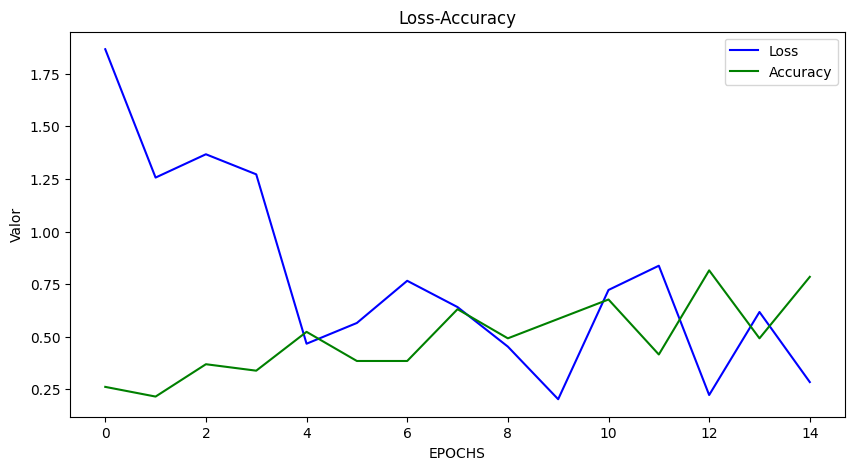

In [25]:
hist(loss_values, acc_values)

# Mejora de resultados

## Búsqueda y aplicación de nuevas arquitecturas de red

### VGG16

In [26]:
# Cargamos el modelo pre-entrenado VGG-16
model_vgg = models.vgg16(pretrained=True)

# Congelamos los pesos de todas las capas del modelo
for param in model_vgg.parameters():
    param.requires_grad = False

# Obtenemos el número de características de la capa de
# entrada del clasificador original
num_features = model_vgg.classifier[-1].in_features

# Modificamos el clasificador final para adaptarse a nuestro número de clases
model_vgg.classifier[-1] = nn.Linear(in_features=num_features,
                                     out_features=num_classes)

loss_values, acc_values = train(model_vgg, train_loader, test_loader, EPOCHS)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:12<00:00, 44.3MB/s]


Epoch: 0, Loss: 1.6774, Accuracy: 0.5077
Epoch: 1, Loss: 1.2189, Accuracy: 0.7077
Epoch: 2, Loss: 0.9165, Accuracy: 0.6769
Epoch: 3, Loss: 0.7681, Accuracy: 0.7231
Epoch: 4, Loss: 0.7828, Accuracy: 0.7538
Epoch: 5, Loss: 0.8218, Accuracy: 0.6923
Epoch: 6, Loss: 0.7362, Accuracy: 0.7692
Epoch: 7, Loss: 0.9783, Accuracy: 0.7538
Epoch: 8, Loss: 0.5234, Accuracy: 0.7692
Epoch: 9, Loss: 0.8793, Accuracy: 0.8
Epoch: 10, Loss: 0.5981, Accuracy: 0.7846
Epoch: 11, Loss: 0.4766, Accuracy: 0.8
Epoch: 12, Loss: 0.3888, Accuracy: 0.8154
Epoch: 13, Loss: 0.9225, Accuracy: 0.7846
Epoch: 14, Loss: 0.4429, Accuracy: 0.8


In [27]:
acc = accuracy(model_vgg, test_loader)
print(acc)
name = "VGG"
models_results.append({'Model': name, 'accuracy': acc})
accuracy_results.append((name, acc_values))

0.8


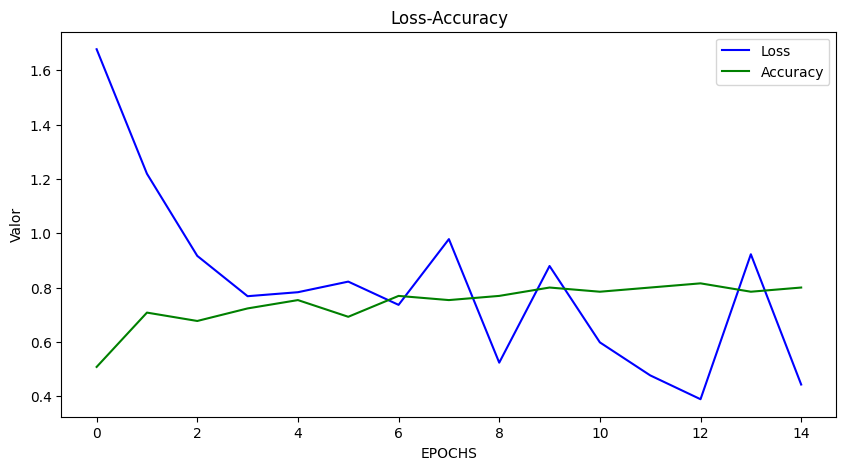

In [28]:
hist(loss_values, acc_values)

### Resnet50

In [29]:
# Cargamos el modelo pre-entrenado ResNet-50
model_resnet = models.resnet50(pretrained=True)

# Congelamos los pesos de todas las capas del modelo VGG-16 (esto parece ser
# un error ya que se hace referencia al modelo anterior)
for param in model_resnet.parameters():
    param.requires_grad = False

# Obtenemos el número de características de la capa de entrada
# del clasificador original
num_ftrs = model_resnet.fc.in_features

# Modificamos la capa final del clasificador para adaptarse
# a nuestro número de clases
model_resnet.fc = nn.Linear(num_ftrs, num_classes)

loss_values, acc_values = train(model_resnet, train_loader, test_loader, EPOCHS)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


Epoch: 0, Loss: 1.7388, Accuracy: 0.2308
Epoch: 1, Loss: 1.3981, Accuracy: 0.3077
Epoch: 2, Loss: 1.722, Accuracy: 0.3846
Epoch: 3, Loss: 1.2502, Accuracy: 0.5077
Epoch: 4, Loss: 1.1677, Accuracy: 0.6154
Epoch: 5, Loss: 1.2219, Accuracy: 0.6308
Epoch: 6, Loss: 0.9872, Accuracy: 0.6308
Epoch: 7, Loss: 0.8945, Accuracy: 0.6308
Epoch: 8, Loss: 1.1748, Accuracy: 0.6615
Epoch: 9, Loss: 0.6922, Accuracy: 0.6923
Epoch: 10, Loss: 0.9757, Accuracy: 0.7077
Epoch: 11, Loss: 0.7458, Accuracy: 0.7231
Epoch: 12, Loss: 0.5898, Accuracy: 0.7077
Epoch: 13, Loss: 0.6208, Accuracy: 0.7538
Epoch: 14, Loss: 0.7901, Accuracy: 0.7692


In [30]:
acc = accuracy(model_resnet, test_loader)
print(acc)
name = "Resnet"
models_results.append({'Model': name, 'accuracy': acc})
accuracy_results.append((name, acc_values))

0.7692


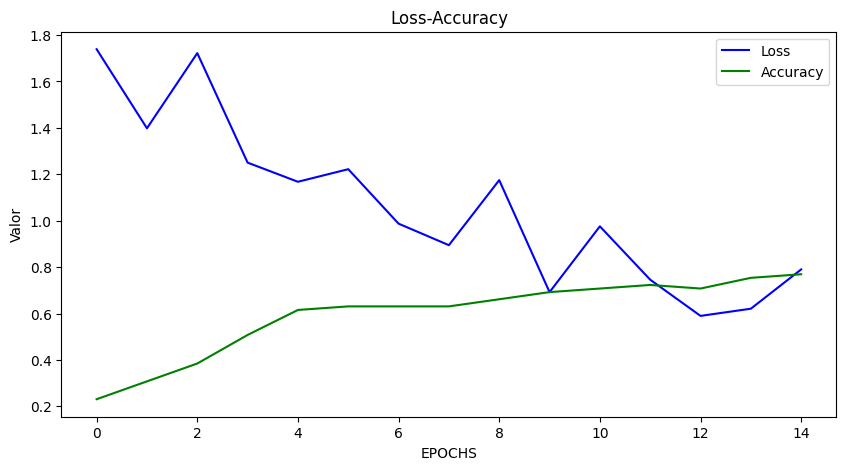

In [31]:
hist(loss_values, acc_values)

### Alexnet

In [32]:
# Cargamos el modelo pre-entrenado AlexNet
model_alexnet = models.alexnet(pretrained=True)

# Congelamos los pesos de todas las capas del modelo VGG-16
# (esto parece ser un error ya que se hace referencia al modelo anterior)
for param in model_alexnet.parameters():
    param.requires_grad = False

# Obtenemos el número de características de la capa de entrada
# del clasificador original
num_features = model_alexnet.classifier[-1].in_features

# Modificamos la capa final del clasificador para adaptarse a nuestro
# número de clases
model_alexnet.classifier[-1] = nn.Linear(in_features=num_features,
                                         out_features=num_classes)

loss_values, acc_values = train(model_alexnet, train_loader,
                                test_loader, EPOCHS)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 51.3MB/s]


Epoch: 0, Loss: 1.112, Accuracy: 0.7077
Epoch: 1, Loss: 0.5526, Accuracy: 0.7692
Epoch: 2, Loss: 0.104, Accuracy: 0.8
Epoch: 3, Loss: 0.0176, Accuracy: 0.8462
Epoch: 4, Loss: 0.1394, Accuracy: 0.8462
Epoch: 5, Loss: 0.2364, Accuracy: 0.8615
Epoch: 6, Loss: 0.3282, Accuracy: 0.8308
Epoch: 7, Loss: 0.0365, Accuracy: 0.8462
Epoch: 8, Loss: 0.1591, Accuracy: 0.8462
Epoch: 9, Loss: 0.1731, Accuracy: 0.8462
Epoch: 10, Loss: 0.0482, Accuracy: 0.8462
Epoch: 11, Loss: 0.0728, Accuracy: 0.8462
Epoch: 12, Loss: 0.1105, Accuracy: 0.8462
Epoch: 13, Loss: 0.0843, Accuracy: 0.8615
Epoch: 14, Loss: 0.1916, Accuracy: 0.8615


In [33]:
acc = accuracy(model_alexnet, test_loader)
print(acc)
name = "Alexnet"
models_results.append({'Model': name, 'accuracy': acc})
accuracy_results.append((name, acc_values))

0.8615


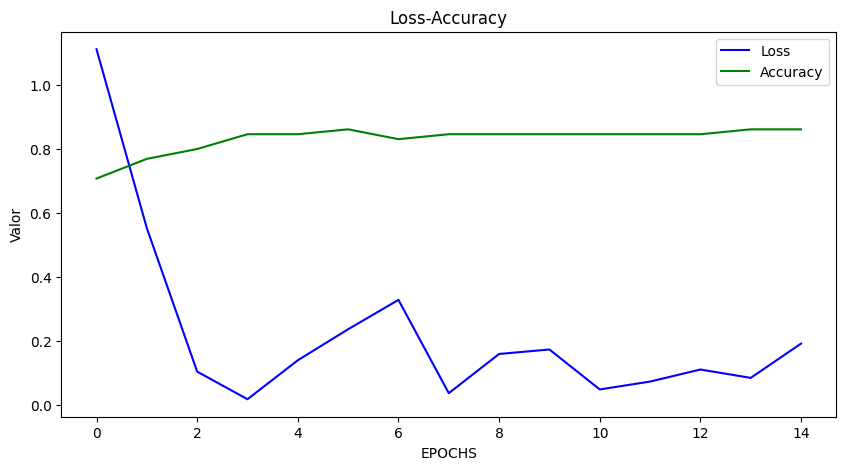

In [34]:
hist(loss_values, acc_values)

### Mobilenet


In [35]:
# Cargamos el modelo pre-entrenado MobileNetV3-Large
model_mobilenet = models.mobilenet_v3_large(pretrained=True)

# Congelamos los pesos de todas las capas del modelo VGG-16
# (esto parece ser un error ya que se hace referencia al modelo anterior)
for param in model_mobilenet.parameters():
    param.requires_grad = False

# Obtenemos el número de características de la capa de entrada
# del clasificador original
num_features = model_mobilenet.classifier[-1].in_features

# Modificamos la capa final del clasificador para adaptarse
# a nuestro número de clases
model_mobilenet.classifier[-1] = nn.Linear(in_features=num_features,
                                           out_features=num_classes)

loss_values, acc_values = train(model_mobilenet, train_loader,
                                test_loader, EPOCHS)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 87.9MB/s]


Epoch: 0, Loss: 1.6216, Accuracy: 0.3692
Epoch: 1, Loss: 1.4703, Accuracy: 0.4769
Epoch: 2, Loss: 1.2862, Accuracy: 0.5846
Epoch: 3, Loss: 1.477, Accuracy: 0.6462
Epoch: 4, Loss: 1.5256, Accuracy: 0.6308
Epoch: 5, Loss: 1.1208, Accuracy: 0.6615
Epoch: 6, Loss: 1.1612, Accuracy: 0.6462
Epoch: 7, Loss: 0.366, Accuracy: 0.6769
Epoch: 8, Loss: 0.7359, Accuracy: 0.6923
Epoch: 9, Loss: 1.0232, Accuracy: 0.6769
Epoch: 10, Loss: 0.8542, Accuracy: 0.6769
Epoch: 11, Loss: 0.6153, Accuracy: 0.6923
Epoch: 12, Loss: 1.1384, Accuracy: 0.7385
Epoch: 13, Loss: 0.9072, Accuracy: 0.7385
Epoch: 14, Loss: 0.2158, Accuracy: 0.7385


In [36]:
acc = accuracy(model_mobilenet, test_loader)
print(acc)
name = "Mobilenet"
models_results.append({'Model': name, 'accuracy': acc})
accuracy_results.append((name, acc_values))

0.7385


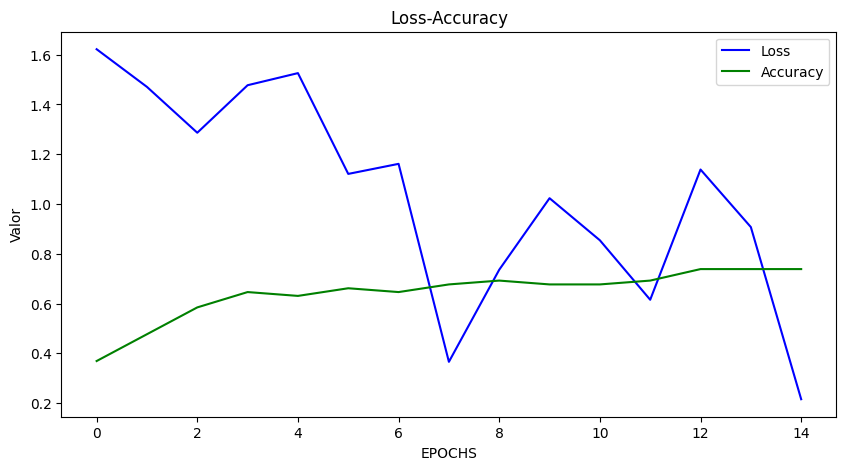

In [37]:
hist(loss_values, acc_values)

## Aumento y agregación de datos o aumento por transformación de las imágenes originales

In [38]:
# Definimos una secuencia de transformaciones para el aumento de datos
# durante el entrenamiento
transformations = transforms.Compose([
    # Volteo horizontal aleatorio de las imágenes
    RandomHorizontalFlip(),
    # Volteo vertical aleatorio de las imágenes
    RandomVerticalFlip(),
    # Rotación aleatoria de las imágenes en un rango de ±45 grados
    RandomRotation(45),
    # Ajustes aleatorios en brillo, contraste, saturación y tono de las imágenes
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Transformación aleatoria que incluye rotación, traslación y cizallamiento
    RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10)
])

In [39]:
augmented_dataset = []
for image, label in dataset:
    augmented_image = transformations(image)
    augmented_dataset.append((augmented_image, label))

augmented_dataset = TensorDataset(torch.stack([image for image, _ in augmented_dataset]),
                                  torch.Tensor([label for _, label in augmented_dataset]))

In [40]:
train_size_aug = int(0.8 * len(augmented_dataset))
test_size_aug = len(augmented_dataset) - train_size
train_dataset_aug, test_dataset_aug = random_split(augmented_dataset,
                                                  [train_size, test_size])

In [41]:
train_loader_aug = DataLoader(train_dataset_aug,
                              batch_size=BATCH_SIZE, shuffle=True)
test_loader_aug = DataLoader(test_dataset_aug,
                             batch_size=BATCH_SIZE, shuffle=False)

In [42]:
model_aug = model_resnet
loss_values, acc_values = train(model_aug, train_loader_aug,
                                test_loader_aug, EPOCHS)

Epoch: 0, Loss: 1.8166, Accuracy: 0.4462
Epoch: 1, Loss: 1.5143, Accuracy: 0.6462
Epoch: 2, Loss: 1.0837, Accuracy: 0.6308
Epoch: 3, Loss: 1.2351, Accuracy: 0.5846
Epoch: 4, Loss: 1.0898, Accuracy: 0.6308
Epoch: 5, Loss: 1.1362, Accuracy: 0.5846
Epoch: 6, Loss: 0.6766, Accuracy: 0.7231
Epoch: 7, Loss: 0.7358, Accuracy: 0.7077
Epoch: 8, Loss: 0.9432, Accuracy: 0.6923
Epoch: 9, Loss: 0.6394, Accuracy: 0.6923
Epoch: 10, Loss: 0.7474, Accuracy: 0.7077
Epoch: 11, Loss: 0.6407, Accuracy: 0.7077
Epoch: 12, Loss: 0.8864, Accuracy: 0.7385
Epoch: 13, Loss: 0.7785, Accuracy: 0.7538
Epoch: 14, Loss: 0.6248, Accuracy: 0.7231


In [43]:
acc = accuracy(model_aug, test_loader_aug)
print(acc)
name = "Model aug"
models_results.append({'Model': name, 'accuracy': acc})
accuracy_results.append((name, acc_values))

0.7231


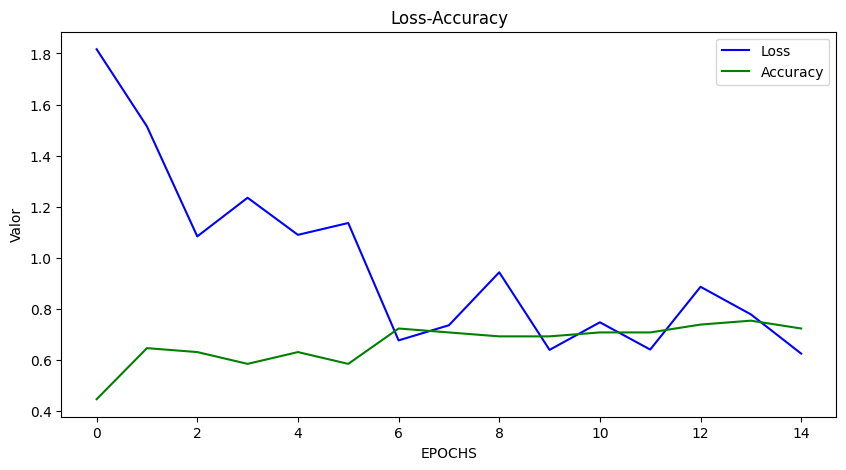

In [44]:
hist(loss_values, acc_values)

## Fine-tunning de los parámetros de la red

In [45]:
model_ft = model_resnet
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
# Permitimos que los gradientes se calculen y actualicen para los
# parámetros de la capa layer4
for param in model_ft.layer4.parameters():
    param.requires_grad = True

# Permitimos que los gradientes se calculen y actualicen para los
# parámetros de la capa completamente conectada (fully connected)
for param in model_ft.fc.parameters():
    param.requires_grad = True

In [47]:
loss_values, acc_values = train(model_ft, train_loader, test_loader, EPOCHS)

Epoch: 0, Loss: 1.9011, Accuracy: 0.4615
Epoch: 1, Loss: 0.0715, Accuracy: 0.7231
Epoch: 2, Loss: 0.0983, Accuracy: 0.8462
Epoch: 3, Loss: 0.1255, Accuracy: 0.8615
Epoch: 4, Loss: 0.0256, Accuracy: 0.8923
Epoch: 5, Loss: 0.0196, Accuracy: 0.9231
Epoch: 6, Loss: 0.0989, Accuracy: 0.9231
Epoch: 7, Loss: 0.0274, Accuracy: 0.9231
Epoch: 8, Loss: 0.0179, Accuracy: 0.9385
Epoch: 9, Loss: 0.0162, Accuracy: 0.9385
Epoch: 10, Loss: 0.0273, Accuracy: 0.9231
Epoch: 11, Loss: 0.0024, Accuracy: 0.9385
Epoch: 12, Loss: 0.0187, Accuracy: 0.9385
Epoch: 13, Loss: 0.0239, Accuracy: 0.9385
Epoch: 14, Loss: 0.0109, Accuracy: 0.9385


In [48]:
acc = accuracy(model_ft, test_loader)
print(acc)
name = "Model fine-tunning"
models_results.append({'Model': name, 'accuracy': acc})
accuracy_results.append((name, acc_values))

0.9385


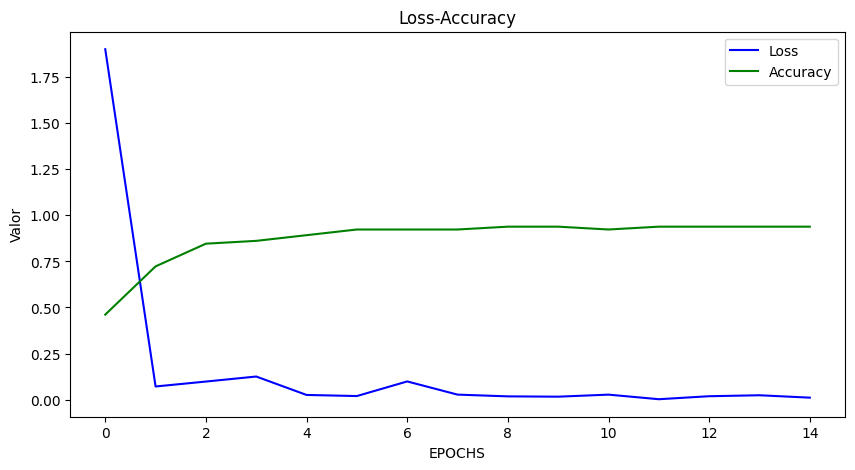

In [49]:
hist(loss_values, acc_values)

# Obtención de nuevas métricas

## Comparativa de resultados

<Figure size 1000x500 with 0 Axes>

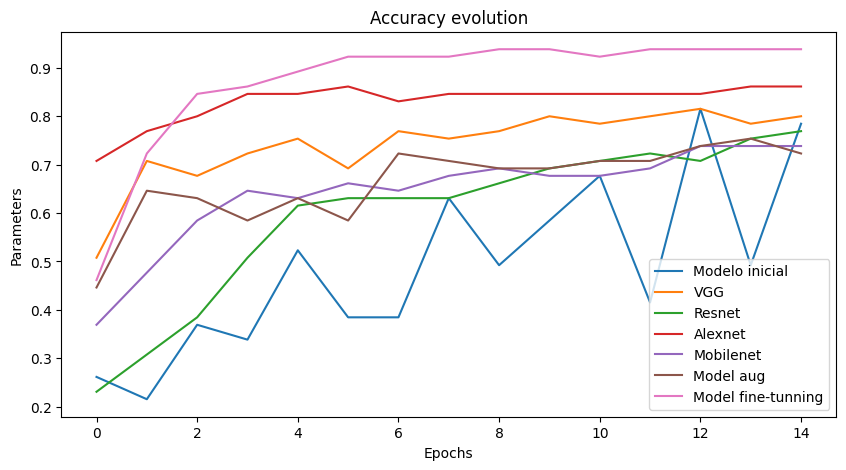

In [50]:
# Se crea un grafico con una representacion lineal para cada uno de los modelos
# entrenados para comparar el accuracy de cada uno
plt.figure(figsize=(10,5))
colors = plt.cm.tab10.colors
plt.figure(figsize=(10,5))
for i, (name_model, acc) in enumerate(accuracy_results):
    plt.plot(acc, label=name_model, color=colors[i % len(colors)])
plt.title('Accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Parameters')
plt.legend()
plt.show()

In [51]:
df_results = pd.DataFrame(models_results)
df_results.style.background_gradient(cmap="Blues")

,Model,accuracy
0,Modelo inicial,0.784600
1,VGG,0.800000
2,Resnet,0.769200
3,Alexnet,0.861500
4,Mobilenet,0.738500
5,Model aug,0.723100
6,Model fine-tunning,0.938500


In [52]:
# Se prueban los modelos para ver las predicciones que devuelven ante
# las imagenes recogidas
model_resnet.eval()

# Cargar la imagen
image = transformed_images[200]

# Aplicar la transformación a la imagen
image_tensor = image.unsqueeze(0)  # Añadir dimensión del batch

image_tensor = image_tensor.to(device)
# Pasar la imagen al modelo
with torch.no_grad():
    outputs = model_mobilenet(image_tensor)
    probabilities = torch.softmax(outputs, dim=1)

# Obtener la clase predicha
predicted_class = torch.argmax(probabilities, dim=1).item()
predicted_probability = probabilities[0][predicted_class].item()

# Imprimir la clase predicha y la probabilidad
print("Clase predicha:", predicted_class)
print("Marca predicha:", brands_logos[predicted_class])
print("Probabilidad:", predicted_probability)

Clase predicha: 5
Marca predicha: Taco Bell logo
Probabilidad: 0.7424851655960083


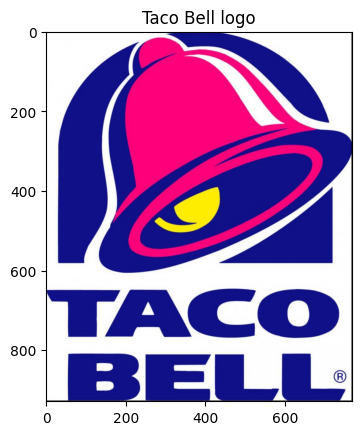

In [53]:
plt.imshow(images[200])
plt.title(
    brands_logos[labels[200]]
)
plt.show()